## Newspaper Churn
### Model Training

In [1]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble pipeline(s)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# PMML Pipeline(s)
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# Model Selection
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold

In [2]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# Newspaper churn dataset
# It contains 15.855 records and 19 columns including the target variable Subscriber (YES/NO).
# The majority of the features is categorial.
df_train = pd.read_csv('../../../data/newspaper-churn-train.csv')
df_test = pd.read_csv('../../../data/newspaper-churn-test.csv')
df_test.sample(10)

,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,target
734,"$ 20,000 - $29,999",RENTER,Hispanic,N,2,30-34,Spanish,ANAHEIM,ORANGE,92805,$0.01 - $0.50,SunOnly,FE,0,Internet,1
61,"$400,000 - $499,999",OWNER,Hispanic,N,22,45-49,English,SANTA ANA,ORANGE,92707,$0 - $0.01,SunOnly,FM,0,Partner,1
3061,"$ 20,000 - $29,999",RENTER,Korean,N,1,65-69,Korean,GARDEN GROVE,ORANGE,92840,$2.00 - $2.99,Thu-Sun,FE,0,Crew,0
4866,"$100,000 - $124,999",OWNER,Hispanic,N,16,50-54,Spanish,SANTA ANA,ORANGE,92703,$0 - $0.01,SunOnly,MW,0,Partner,0
846,"Under $20,000",OWNER,Hispanic,N,38,75 years or more,English,STANTON,ORANGE,90680,$7.00 - $7.99,7Day,FE,0,Crew,0
1207,"$400,000 - $499,999",OWNER,Jewish,N,2,65-69,English,TRABUCO CANYON,ORANGE,92679,$0.51 - $0.99,7Day,FW,14,AdvAdm,0
4566,"$ 60,000 - $69,999",RENTER,Hispanic,N,3,30-34,Spanish,STANTON,ORANGE,90680,$0.01 - $0.50,SunOnly,FM,0,Partner,1
2293,"$125,000 - $149,999",OWNER,unknown,N,4,35-39,English,SAN CLEMENTE,ORANGE,92673,$0.51 - $0.99,7Day,YW,0,CustCall,0
2829,"$ 80,000 - $89,999",OWNER,Arab,Y,26,60-64,Arabic,WESTMINSTER,ORANGE,92683,$0 - $0.01,SunOnly,FM,0,Partner,0
1329,"$100,000 - $124,999",OWNER,English,N,20,75 years or more,English,ANAHEIM,ORANGE,92806,$10.00 - $10.99,7Day,MW,0,CustCall,1


## Ensemble of models

In [5]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

In [6]:
# Ensemble of models
estimator = []
estimator.append(('lrc',LogisticRegression(warm_start=True, max_iter=400)))
estimator.append(('xgb', XGBClassifier(tree_method="hist", verbosity=0, silent=True)))
estimator.append(('rfc', RandomForestClassifier()))
estimator.append(('dtc', DecisionTreeClassifier()))

In [7]:
ppl_ensemble = Pipeline([
    # Step 1: Impute and scale features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler()),
         make_column_selector(dtype_include='int64')
         ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown = 'ignore')),
         make_column_selector(dtype_exclude=['int64'])
         )])
     ),

    # Step 2: Voting Classifier
    ('ensemble', VotingClassifier(estimators = estimator, voting ='soft'))

])

In [8]:
display(ppl_ensemble)

Pipeline(steps=[('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x142bfc370>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   O...nknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x142bffac0>)])),
                ('ensemble',
                 VotingClassifier(estimators=[('lrc',
                                               LogisticRegression(max_iter=400,
                                                                  warm_start=True)),
                                              ('xgb',
                                               XGBClassifier(silent=True,
                                                             tree_method='hist',
                                                             verbosity=0)),
                                              ('rfc', RandomForestClassifier()),
                                              ('dtc',
                                               DecisionTreeClassifier())],
                                  voting='soft'))])

## Hyper-parameter Tuning

In [9]:
ppl_ensemble.get_params(3)

{'memory': None,
 'steps': [('cleaning', ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x142bfc370>),
                                   ('cat',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x142bffac0>)])),
 

In [10]:
# Hyper-parameter
hyper_params = {
    'ensemble__lrc__solver': ['newton-cg'],
    'ensemble__xgb__reg_alpha': [0.1,0.5],
    'ensemble__rfc__max_depth': [7,10],
    'ensemble__dtc__max_depth': [7,10]
}

cv_rsf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)

In [11]:
# Create pipeline with logistic regression as classifier
ppl_tuning = PMMLPipeline(steps=[
    ('hyper-tuning', RandomizedSearchCV(ppl_ensemble, param_distributions=hyper_params, scoring='roc_auc', verbose=2, cv=cv_rsf))
])

ppl_tuning.fit(X_train, y_train)
ppl_tuning.verify(X_train.sample(n = 10))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   1.2s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.1; total time=   1.0s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   1.0s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=7, ensemble__xgb__reg_alpha=0.5; total time=   1.0s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   1.3s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__xgb__reg_alpha=0.1; total time=   1.3s
[CV] END ensemble__dtc__max_depth=7, ensemble__lrc__solv

In [12]:
# summarize result
# print('Best Score: %s' % ppl_tuning.best_score_)
# print('Best Hyperparameters: %s' % ppl_tuning.best_params_)

In [13]:
y_pred = ppl_tuning.predict(X_test)

In [14]:
# using accuracy_score
from sklearn.metrics import f1_score

print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 82.3%
The model f1 score is: 82.3%


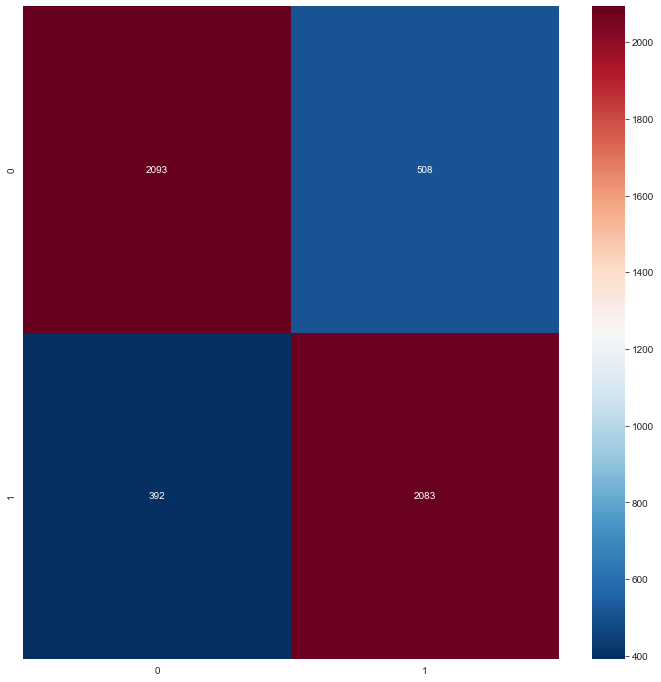

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=ppl_tuning.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=ppl_tuning.classes_, yticklabels=ppl_tuning.classes_, fmt='g', annot=True)
plt.show()

<Figure size 2160x2160 with 0 Axes>

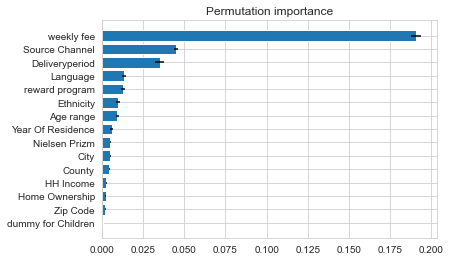

In [16]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    plt.figure(figsize=(30, 30))
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    tmp = np.array(feat_name)
    ax.set_yticklabels(tmp[indices])
    ax.set_title("Permutation importance")

ppl_ensemble.fit(X_test,y_test)
features = ppl_ensemble.get_feature_names_out()
perm_importance_result_train = permutation_importance(ppl_tuning, X_test, y_test)
plot_feature_importances(perm_importance_result_train, X_test.columns)

## Save the mode

In [17]:
# Save the best model in PMML format
sklearn2pmml(ppl_tuning, "../../../data/newspaper-churn-train-ensemble-classifier.pmml")